# Streamflow Prediction with Automatic Feature Learning

This notebook demonstrates how to leverage deep learning's **automatic feature learning** capabilities instead of manual feature engineering.

## Key Differences from Manual Approach:
- ✅ Feed raw time series data directly to the model
- ✅ Let the model learn temporal patterns automatically
- ✅ Use attention mechanisms to identify important time steps
- ✅ Reduce preprocessing complexity
- ✅ Compare with manual feature engineering approach

## Architectures Used:
1. **Deep LSTM with Multiple Layers** - Learns hierarchical temporal features
2. **LSTM with Attention** - Learns which past time steps are important
3. **Temporal Convolutional Network (TCN)** - Learns local patterns efficiently
4. **Transformer** - Self-attention for long-range dependencies

## 1. Setup

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import boto3
import io
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

Using device: cuda


## 2. Data Generation (Same as Before)

We'll use the same synthetic data, but **without manual feature engineering**.

In [41]:
# load data
DATA_KEY = 'lamar_river_streamflow.csv'  

df = pd.read_csv(DATA_KEY)

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nStreamflow statistics:")
print(df['streamflow'].describe())



Dataset shape: (9902, 3)
Date range: 1998-10-01 00:00:00+00:00 to 2025-11-20 00:00:00+00:00

First few rows:
                        date  streamflow_cfs  streamflow
0  1998-10-01 00:00:00+00:00            14.0    0.396435
1  1998-10-02 00:00:00+00:00            17.0    0.481386
2  1998-10-03 00:00:00+00:00            17.0    0.481386
3  1998-10-04 00:00:00+00:00            16.0    0.453069
4  1998-10-05 00:00:00+00:00            15.0    0.424752

Streamflow statistics:
count    9902.000000
mean        1.789949
std         3.642307
min         0.011893
25%         0.096914
50%         0.269293
75%         1.076038
max        30.865312
Name: streamflow, dtype: float64


In [42]:
# Quick visualization
plt.figure(figsize=(14, 4))
plt.plot(df['date'], df['streamflow'], linewidth=0.8, alpha=0.8)
plt.title('Raw Streamflow Time Series (No Manual Features)', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## 3. Simple Data Preparation - Just Raw Sequences!

**Key Point**: We're feeding ONLY the raw streamflow values - no manual features!

In [87]:
def create_sequences_raw(data, seq_length=60, forecast_horizon=1):
    """Create sequences from raw time series data."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    X = np.array(X).reshape(-1, seq_length, 1)
    return X, np.array(y)

# Use only streamflow values (automatic feature learning!)
streamflow_values = df['streamflow'].values

# Split: 70% train, 15% val, 15% test
train_size = int(0.70 * len(streamflow_values))
val_size = int(0.15 * len(streamflow_values))

train_data = streamflow_values[:train_size]
val_data = streamflow_values[train_size:train_size + val_size]
test_data = streamflow_values[train_size + val_size:]

print(f"Training period: {df['date'].iloc[0]} to {df['date'].iloc[train_size-1]}")
print(f"Validation period: {df['date'].iloc[train_size]} to {df['date'].iloc[train_size+val_size-1]}")
print(f"Test period: {df['date'].iloc[train_size+val_size]} to {df['date'].iloc[-1]}")

# Scale data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_data_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create sequences
SEQ_LENGTH = 365  # days of history to use
X_train, y_train = create_sequences_raw(train_data_scaled, SEQ_LENGTH)
X_val, y_val = create_sequences_raw(val_data_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences_raw(test_data_scaled, SEQ_LENGTH)

print(f"\nSequence shapes:")
print(f"  Train: {X_train.shape} -> {y_train.shape}")
print(f"  Val:   {X_val.shape} -> {y_val.shape}")
print(f"  Test:  {X_test.shape} -> {y_test.shape}")

# Convert to PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Data ready for training!")
print(f"✓ Using raw streamflow only - model will learn features automatically")

Training period: 1998-10-01 00:00:00+00:00 to 2017-09-24 00:00:00+00:00
Validation period: 2017-09-25 00:00:00+00:00 to 2021-10-18 00:00:00+00:00
Test period: 2021-10-19 00:00:00+00:00 to 2025-11-20 00:00:00+00:00

Sequence shapes:
  Train: (6566, 365, 1) -> (6566,)
  Val:   (1120, 365, 1) -> (1120,)
  Test:  (1121, 365, 1) -> (1121,)

✓ Data ready for training!
✓ Using raw streamflow only - model will learn features automatically


## 4. Advanced Model Architectures for Automatic Feature Learning

These models learn features automatically from raw sequences.

In [88]:
class DeepLSTM(nn.Module):
    """Deep LSTM with multiple layers for hierarchical feature learning"""
    def __init__(self, input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(DeepLSTM, self).__init__()
        
        # Stack multiple LSTM layers
        self.lstm_layers = nn.ModuleList()
        
        # First layer
        self.lstm_layers.append(
            nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        )
        
        # Middle layers
        for i in range(len(hidden_sizes) - 1):
            self.lstm_layers.append(
                nn.LSTM(hidden_sizes[i], hidden_sizes[i+1], batch_first=True)
            )
        
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_sizes[-1], 1)
    
    def forward(self, x):
        # Pass through each LSTM layer
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
            x = self.dropout(x)
        
        # Take last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


class AttentionLSTM(nn.Module):
    """LSTM with attention mechanism to learn important time steps"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # Get LSTM outputs for all time steps
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        
        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Apply attention weights
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, hidden_size)
        
        out = self.fc(context)
        return out.squeeze()


class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network for efficient local pattern learning"""
    def __init__(self, input_size=1, num_channels=[64, 128, 64], kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Dilated causal convolution
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size, 
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Conv1d(out_channels, out_channels, kernel_size,
                         padding=padding, dilation=dilation),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        # Conv1d expects: (batch, features, seq_len)
        x = x.transpose(1, 2)
        
        x = self.network(x)
        
        # Global average pooling
        x = torch.mean(x, dim=2)
        
        out = self.fc(x)
        return out.squeeze()


class TransformerModel(nn.Module):
    """Transformer with self-attention for long-range dependencies"""
    def __init__(self, input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Learnable positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 200, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project and add positional encoding
        x = self.input_proj(x)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Use last time step
        x = x[:, -1, :]
        out = self.fc(x)
        return out.squeeze()


print("✅ Model architectures defined")
print("\nAvailable models:")
print("  1. DeepLSTM - Multiple LSTM layers for hierarchical learning")
print("  2. AttentionLSTM - LSTM with attention to identify important time steps")
print("  3. TemporalConvNet (TCN) - Efficient convolutional approach")
print("  4. TransformerModel - Self-attention for long-range dependencies")

✅ Model architectures defined

Available models:
  1. DeepLSTM - Multiple LSTM layers for hierarchical learning
  2. AttentionLSTM - LSTM with attention to identify important time steps
  3. TemporalConvNet (TCN) - Efficient convolutional approach
  4. TransformerModel - Self-attention for long-range dependencies


## 5. Training Function

In [89]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=15):
    """Train a model and return history"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_state)
    return history, best_val_loss


def evaluate_model(model, data_loader, scaler):
    """Evaluate model and return predictions and metrics"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Inverse transform
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)
    nse = 1 - (np.sum((actuals_original - predictions_original) ** 2) / 
               np.sum((actuals_original - np.mean(actuals_original)) ** 2))
    
    metrics = {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'NSE': nse}
    
    return predictions_original, actuals_original, metrics

## 6. Train and Compare All Models

Let's train all models and see how they perform with automatic feature learning!

In [90]:
# Define all models
models = {
    'DeepLSTM': DeepLSTM(input_size=1, hidden_sizes=[128, 64, 32], dropout=0.3),
    'AttentionLSTM': AttentionLSTM(input_size=1, hidden_size=128, num_layers=2, dropout=0.2),
    'TCN': TemporalConvNet(input_size=1, num_channels=[64, 128, 64], dropout=0.2),
    'Transformer': TransformerModel(input_size=1, d_model=128, nhead=8, num_layers=3, dropout=0.2)
}

# Training configuration
EPOCHS = 50
LEARNING_RATE = 0.0001

results = {}

print("Starting training for all models...\n")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining {name}...")
    print("-" * 80)
    
    model = model.to(device)
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {n_params:,}")
    
    # Train
    history, best_val_loss = train_model(model, train_loader, val_loader, 
                                          epochs=EPOCHS, lr=LEARNING_RATE)
    
    # Evaluate
    test_preds, test_actuals, test_metrics = evaluate_model(model, test_loader, scaler)
    
    results[name] = {
        'model': model,
        'history': history,
        'test_preds': test_preds,
        'test_actuals': test_actuals,
        'metrics': test_metrics,
        'n_params': n_params
    }
    
    print(f"\nTest Results:")
    print(f"  RMSE: {test_metrics['RMSE']:.3f}")
    print(f"  MAE:  {test_metrics['MAE']:.3f}")
    print(f"  R²:   {test_metrics['R²']:.4f}")
    print(f"  NSE:  {test_metrics['NSE']:.4f}")

print("\n" + "=" * 80)
print("✅ All models trained!")

Starting training for all models...


Training DeepLSTM...
--------------------------------------------------------------------------------
Parameters: 129,313
Epoch [10/50] | Train Loss: 0.114915 | Val Loss: 0.114205
Epoch [20/50] | Train Loss: 0.068233 | Val Loss: 0.054674
Epoch [30/50] | Train Loss: 0.052221 | Val Loss: 0.034666
Epoch [40/50] | Train Loss: 0.043688 | Val Loss: 0.027415
Epoch [50/50] | Train Loss: 0.043991 | Val Loss: 0.024780

Test Results:
  RMSE: 0.408
  MAE:  0.177
  R²:   0.9826
  NSE:  0.9826

Training AttentionLSTM...
--------------------------------------------------------------------------------
Parameters: 224,130
Epoch [10/50] | Train Loss: 0.374363 | Val Loss: 0.354829
Epoch [20/50] | Train Loss: 0.365280 | Val Loss: 0.321541
Epoch [30/50] | Train Loss: 0.360866 | Val Loss: 0.329839
Early stopping at epoch 38

Test Results:
  RMSE: 1.632
  MAE:  0.742
  R²:   0.7226
  NSE:  0.7226

Training TCN...
----------------------------------------------------------

RuntimeError: The size of tensor a (365) must match the size of tensor b (200) at non-singleton dimension 1

## 7. Model Comparison

In [83]:
# Compare all models
print("\n" + "=" * 100)
print("MODEL COMPARISON - Automatic Feature Learning")
print("=" * 100)
print(f"{'Model':<20} {'Parameters':<15} {'RMSE':<12} {'MAE':<12} {'R²':<12} {'NSE':<12}")
print("-" * 100)

for name, result in results.items():
    metrics = result['metrics']
    n_params = result['n_params']
    print(f"{name:<20} {n_params:<15,} {metrics['RMSE']:<12.3f} {metrics['MAE']:<12.3f} "
          f"{metrics['R²']:<12.4f} {metrics['NSE']:<12.4f}")

print("=" * 100)

# Find best model
best_model_name = min(results, key=lambda k: results[k]['metrics']['RMSE'])
print(f"\n🏆 Best Model: {best_model_name} (Lowest RMSE)")


MODEL COMPARISON - Automatic Feature Learning
Model                Parameters      RMSE         MAE          R²           NSE         
----------------------------------------------------------------------------------------------------
DeepLSTM             129,313         0.408        0.142        0.9827       0.9827      
AttentionLSTM        224,130         1.767        0.768        0.6753       0.6753      
TCN                  123,649         0.412        0.154        0.9824       0.9824      

🏆 Best Model: DeepLSTM (Lowest RMSE)


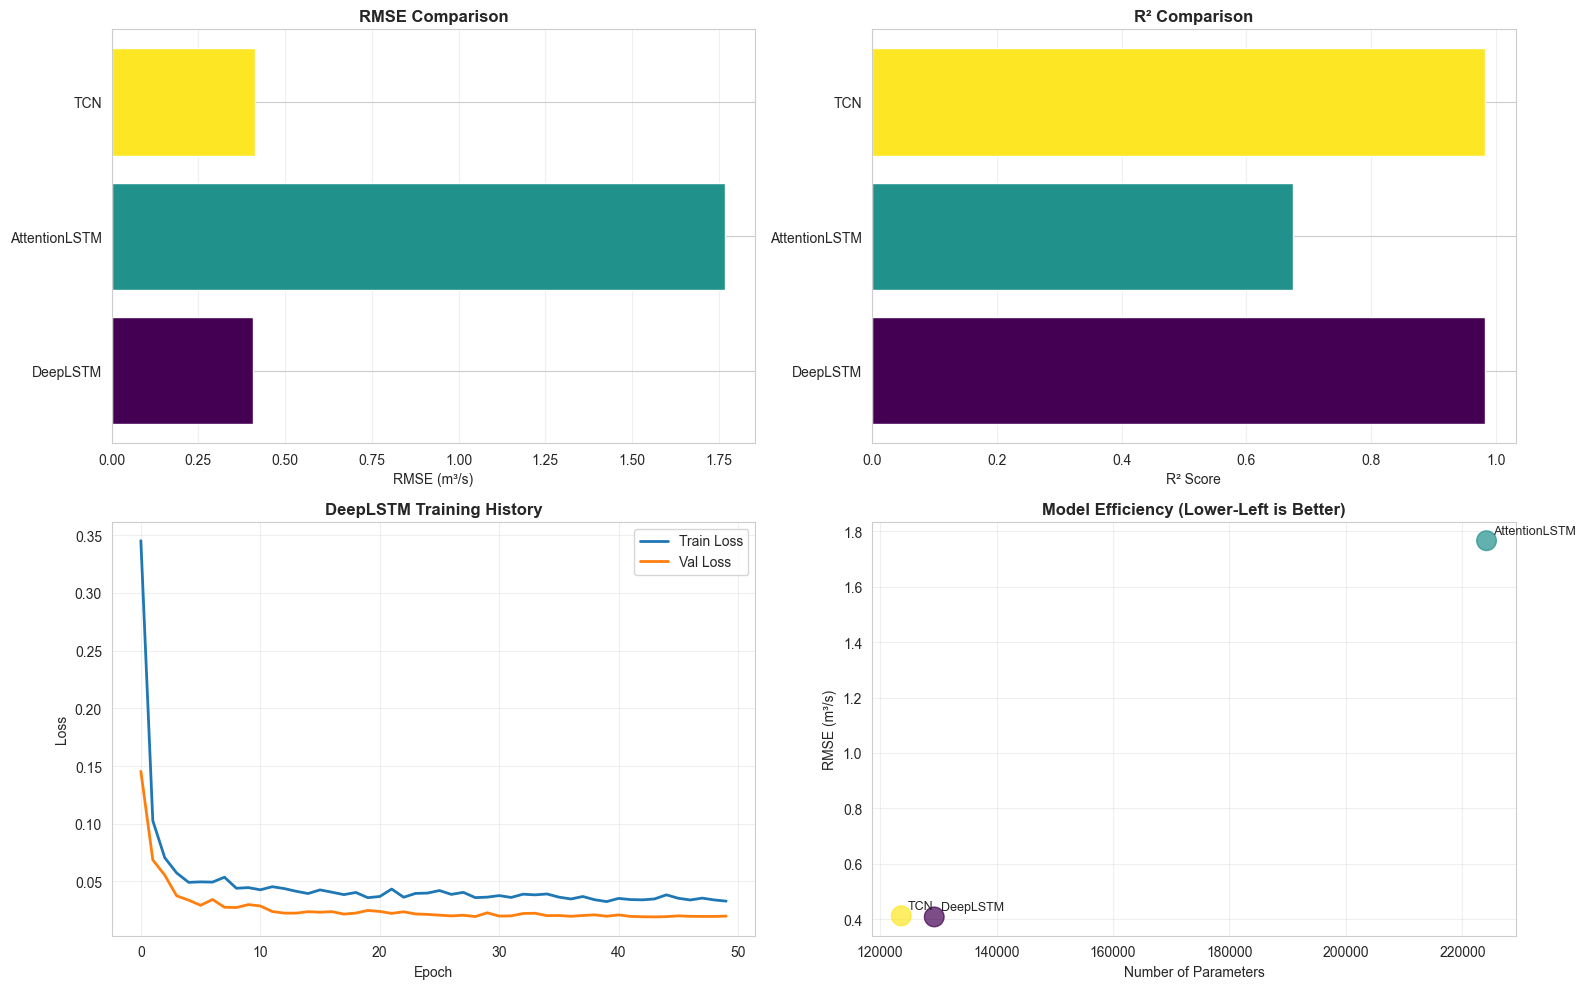

In [84]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. RMSE Comparison
model_names = list(results.keys())
rmse_values = [results[name]['metrics']['RMSE'] for name in model_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

axes[0, 0].barh(model_names, rmse_values, color=colors)
axes[0, 0].set_xlabel('RMSE (m³/s)')
axes[0, 0].set_title('RMSE Comparison', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. R² Comparison
r2_values = [results[name]['metrics']['R²'] for name in model_names]
axes[0, 1].barh(model_names, r2_values, color=colors)
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('R² Comparison', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Training curves for best model
best_history = results[best_model_name]['history']
axes[1, 0].plot(best_history['train_loss'], label='Train Loss', linewidth=2)
axes[1, 0].plot(best_history['val_loss'], label='Val Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title(f'{best_model_name} Training History', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Parameter efficiency
param_counts = [results[name]['n_params'] for name in model_names]
axes[1, 1].scatter(param_counts, rmse_values, s=200, c=colors, alpha=0.7)
for i, name in enumerate(model_names):
    axes[1, 1].annotate(name, (param_counts[i], rmse_values[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1, 1].set_xlabel('Number of Parameters')
axes[1, 1].set_ylabel('RMSE (m³/s)')
axes[1, 1].set_title('Model Efficiency (Lower-Left is Better)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Detailed Analysis of Best Model

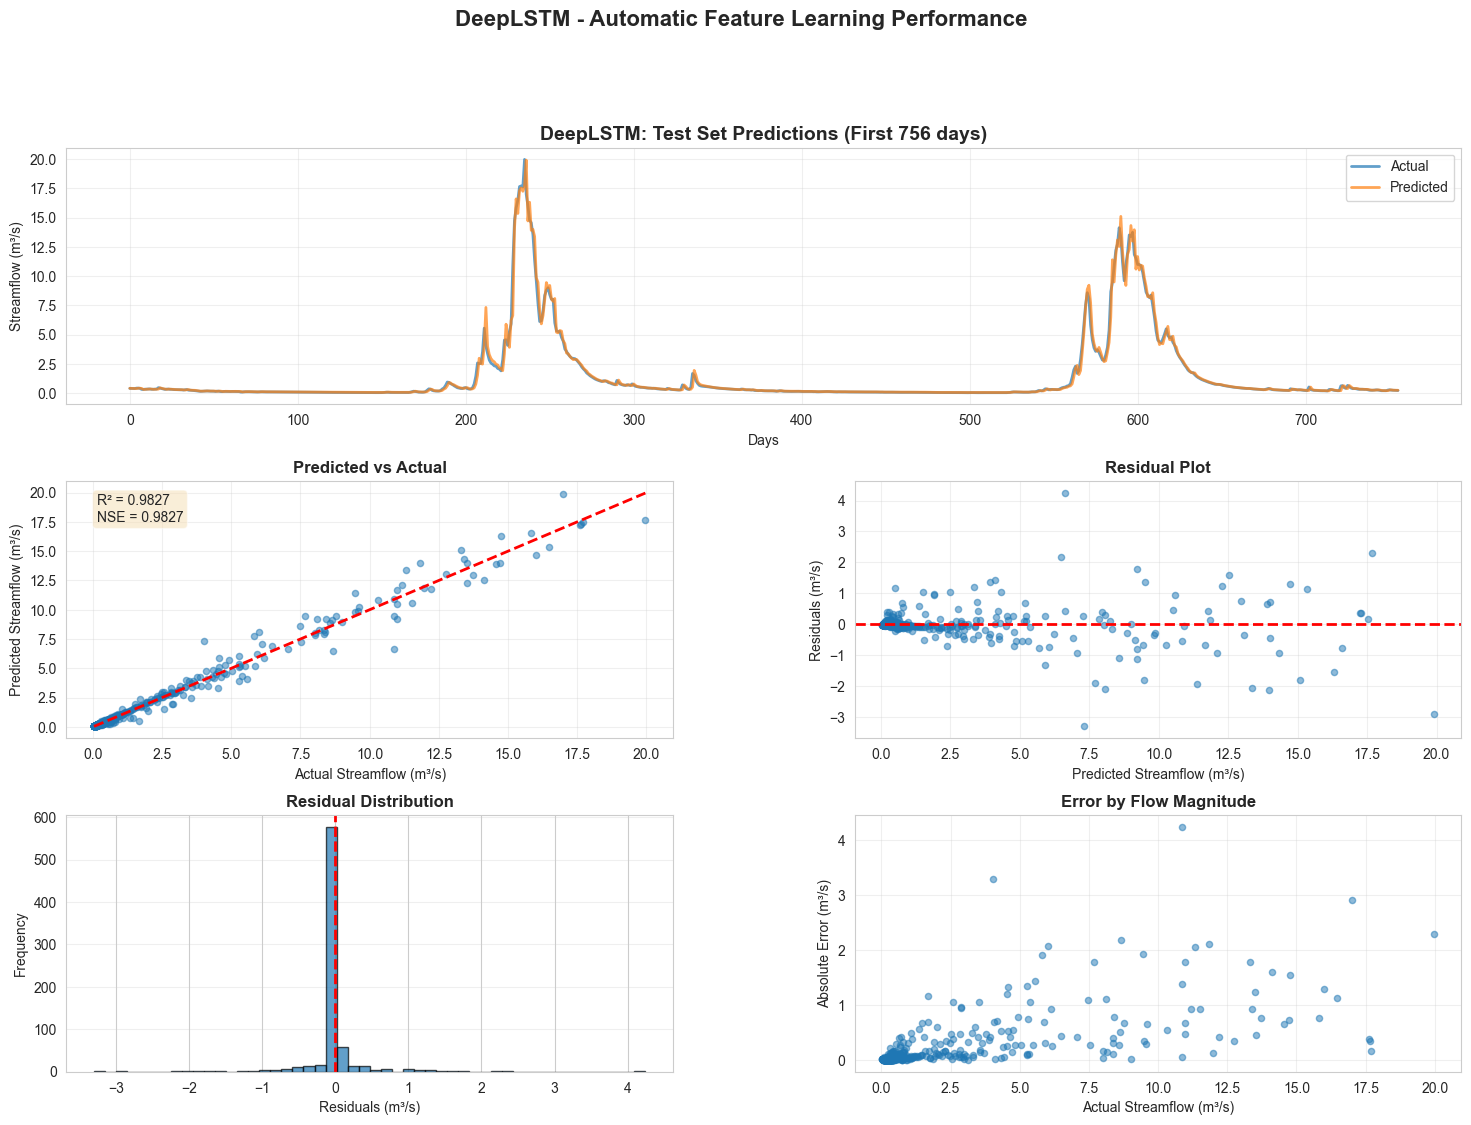

In [85]:
TemporalConvNet# Get best model results
best_result = results[best_model_name]
test_preds = best_result['test_preds']
test_actuals = best_result['test_actuals']

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series comparison
ax1 = fig.add_subplot(gs[0, :])
n_plot = min(1500, len(test_actuals))
ax1.plot(range(n_plot), test_actuals[:n_plot], label='Actual', linewidth=2, alpha=0.7)
ax1.plot(range(n_plot), test_preds[:n_plot], label='Predicted', linewidth=2, alpha=0.7)
ax1.set_title(f'{best_model_name}: Test Set Predictions (First {n_plot} days)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Days')
ax1.set_ylabel('Streamflow (m³/s)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(test_actuals, test_preds, alpha=0.5, s=20)
min_val = min(test_actuals.min(), test_preds.min())
max_val = max(test_actuals.max(), test_preds.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_xlabel('Actual Streamflow (m³/s)')
ax2.set_ylabel('Predicted Streamflow (m³/s)')
ax2.set_title('Predicted vs Actual', fontweight='bold')
ax2.grid(True, alpha=0.3)
metrics_text = f"R² = {best_result['metrics']['R²']:.4f}\nNSE = {best_result['metrics']['NSE']:.4f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Residual plot
ax3 = fig.add_subplot(gs[1, 1])
residuals = test_actuals - test_preds
ax3.scatter(test_preds, residuals, alpha=0.5, s=20)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Streamflow (m³/s)')
ax3.set_ylabel('Residuals (m³/s)')
ax3.set_title('Residual Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Residual distribution
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals (m³/s)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Error by magnitude
ax5 = fig.add_subplot(gs[2, 1])
abs_error = np.abs(residuals)
ax5.scatter(test_actuals, abs_error, alpha=0.5, s=20)
ax5.set_xlabel('Actual Streamflow (m³/s)')
ax5.set_ylabel('Absolute Error (m³/s)')
ax5.set_title('Error by Flow Magnitude', fontweight='bold')
ax5.grid(True, alpha=0.3)

plt.suptitle(f'{best_model_name} - Automatic Feature Learning Performance', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 9. Visualize Attention Weights (for AttentionLSTM)

If using the AttentionLSTM, we can visualize which time steps the model focuses on.

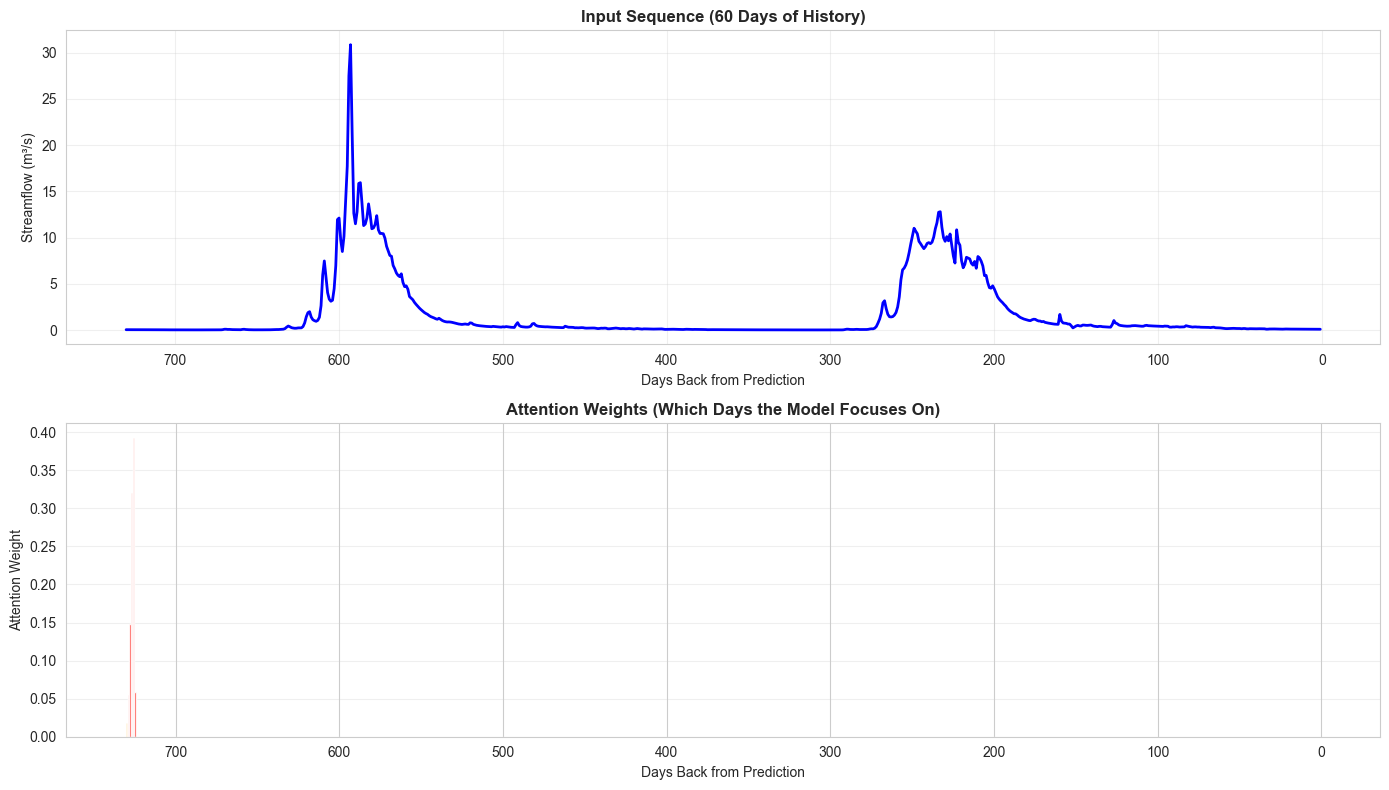


Top 5 most important time steps:
Rank   Days Back    Time Step    Weight    
---------------------------------------------
1      726          4            0.3925
2      727          3            0.3208
3      728          2            0.1482
4      725          5            0.0588
5      729          1            0.0550


In [86]:
  if 'AttentionLSTM' in results:
      attention_model = results['AttentionLSTM']['model']
      attention_model.eval()

      sample_idx = 100
      sample_X = X_test_tensor[sample_idx:sample_idx+1]
      sample_y_actual = y_test_tensor[sample_idx].cpu().numpy()

      with torch.no_grad():
          lstm_out, _ = attention_model.lstm(sample_X)
          attention_weights = attention_model.attention(lstm_out)
          attention_weights = torch.softmax(attention_weights, dim=1)
          attention_weights = attention_weights.squeeze().cpu().numpy()

      # Visualize with CORRECTED labels
      fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

      # Input sequence
      input_seq = scaler.inverse_transform(
          sample_X.squeeze().cpu().numpy().reshape(-1, 1)
      ).flatten()

      # Create "days back" labels (60, 59, 58, ..., 1)
      days_back = np.arange(SEQ_LENGTH, 0, -1)

      ax1.plot(days_back, input_seq, linewidth=2, color='blue')
      ax1.set_xlabel('Days Back from Prediction')
      ax1.set_ylabel('Streamflow (m³/s)')
      ax1.set_title('Input Sequence (60 Days of History)', fontweight='bold')
      ax1.grid(True, alpha=0.3)
      ax1.invert_xaxis()  # So 1 is on the right (most recent)

      # Attention weights
      ax2.bar(days_back, attention_weights, color='orange', alpha=0.7)
      ax2.set_xlabel('Days Back from Prediction')
      ax2.set_ylabel('Attention Weight')
      ax2.set_title('Attention Weights (Which Days the Model Focuses On)', fontweight='bold')
      ax2.grid(True, alpha=0.3, axis='y')
      ax2.invert_xaxis()  # So recent days (1, 2, 3) are on right

      # Highlight top 5
      top_5_idx = np.argsort(attention_weights)[-5:]
      for idx in top_5_idx:
          ax2.bar(days_back[idx], attention_weights[idx], color='red', alpha=0.9)

      plt.tight_layout()
      plt.show()

      print(f"\nTop 5 most important time steps:")
      print(f"{'Rank':<6} {'Days Back':<12} {'Time Step':<12} {'Weight':<10}")
      print("-" * 45)
      for i, idx in enumerate(top_5_idx[::-1]):
          days_ago = SEQ_LENGTH - idx
          print(f"{i+1:<6} {days_ago:<12} {idx:<12} {attention_weights[idx]:.4f}")
  else:
      print("AttentionLSTM not in results")


## 10. Key Insights

### Advantages of Automatic Feature Learning:

1. **✅ Simpler Pipeline**: No need to manually engineer lags, rolling statistics, etc.
2. **✅ Learned Representations**: Model discovers optimal features automatically
3. **✅ Hierarchical Features**: Deep networks learn multi-scale patterns
4. **✅ Attention Mechanisms**: Automatically identify important time steps
5. **✅ Less Domain Knowledge Required**: Don't need to know which lags matter

### When to Use Manual vs Automatic:

**Manual Feature Engineering** (Previous Notebook):
- Smaller datasets (< 1000 samples)
- Need interpretability
- Have strong domain knowledge
- Limited computational resources
- Simple baseline models

**Automatic Feature Learning** (This Notebook):
- Larger datasets (> 5000 samples)
- Complex temporal patterns
- Multiple interacting variables
- Want state-of-the-art performance
- Have computational resources

### Best Practices:

1. **Longer Sequences**: Use 30-90 day lookback for automatic learning
2. **Deeper Networks**: 2-4 layers allow hierarchical feature learning
3. **Attention**: Helps interpret what the model focuses on
4. **Regularization**: Dropout and weight decay prevent overfitting
5. **Ensemble**: Combine multiple architectures for best results

### Next Steps:

1. Add additional input features (temperature, precipitation) as extra channels
2. Try sequence-to-sequence models for multi-step forecasting
3. Implement uncertainty quantification
4. Deploy best model to AWS SageMaker
5. Create ensemble of top models

## 11. Save Best Model to AWS S3

In [76]:
# AWS Configuration (update with your settings)
AWS_REGION = 'us-east-1'
S3_BUCKET = 'your-streamflow-bucket'
S3_MODEL_PREFIX = 'models/streamflow_automl/'

try:
    s3_client = boto3.client('s3', region_name=AWS_REGION)
    
    # Save best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_name = f"streamflow_{best_model_name.lower()}_automl_{timestamp}"
    
    # Save locally
    torch.save(best_result['model'].state_dict(), f"{model_name}.pth")
    
    # Save metadata
    metadata = {
        'model_type': best_model_name,
        'approach': 'automatic_feature_learning',
        'sequence_length': SEQ_LENGTH,
        'n_parameters': best_result['n_params'],
        'test_metrics': best_result['metrics'],
        'training_date': timestamp
    }
    
    with open(f"{model_name}_metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Upload to S3
    s3_client.upload_file(f"{model_name}.pth", S3_BUCKET, f"{S3_MODEL_PREFIX}{model_name}.pth")
    s3_client.upload_file(f"{model_name}_metadata.json", S3_BUCKET, f"{S3_MODEL_PREFIX}{model_name}_metadata.json")
    
    print(f"✅ Model saved to S3: s3://{S3_BUCKET}/{S3_MODEL_PREFIX}{model_name}.pth")
    
except Exception as e:
    print(f"⚠ AWS not configured: {e}")
    print("Model saved locally only")

⚠ AWS not configured: Object of type float32 is not JSON serializable
Model saved locally only
